In [481]:
from warnings import filterwarnings

filterwarnings("ignore")

In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = 'serif'

In [483]:
path = "/home/criuser/LPI Courses/Data & IA/Final Project/Data_processed/"
path_image = "/home/criuser/LPI Courses/Data & IA/Final Project/All_pictures/"

data = pd.read_csv(path+"Sales_forecasting_processed_data.csv",
                        parse_dates=['date'],
                        infer_datetime_format=True,
                       index_col="date"
                        )

<AxesSubplot: xlabel='date'>

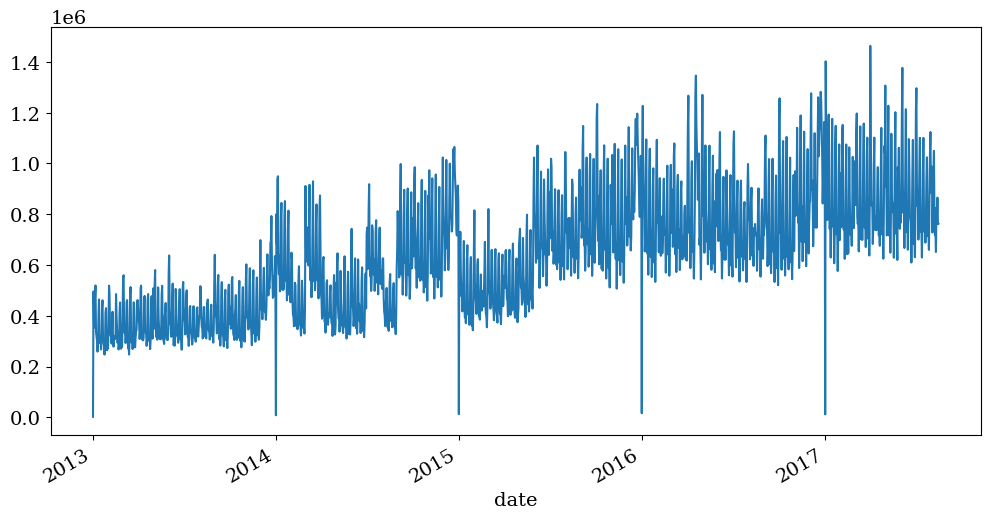

In [484]:
data["sales"].plot()

In [485]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
    else:
        print("No missing value")
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [486]:
# Checking missing values

handle_missing_data(data.sales)

No missing value


In [487]:
sales_data = one_step_forecast(data.sales, 10)

In [488]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [489]:
data.shape, sales_data.shape

((1684, 7), (1674, 11))

In [490]:
sales_data.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
2013-01-01,2511.618999,496092.417944,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085
2013-01-02,496092.417944,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011
2013-01-03,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998
2013-01-04,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998,293348.362078
2013-01-05,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998,293348.362078,299129.549954


In [491]:
scale_data = Standardize(sales_data)

train_data, test_data, val_data = scale_data.fit_transform()

In [492]:
print(f''' train_data: {len(train_data)} , test_data: {len(test_data)}, val_data:{len(val_data)}''')

 train_data: 1357 , test_data: 167, val_data:150


In [493]:
train_data.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
2013-01-01,-2.715914,-0.420845,-1.049958,-1.084148,-0.512276,-0.315409,-1.172024,-1.256578,-1.331825,-1.537413,-1.394221
2013-01-02,-0.417886,-1.049363,-1.082645,-0.510546,-0.314751,-1.171746,-1.254944,-1.330401,-1.535192,-1.393709,-0.864809
2013-01-03,-1.044706,-1.082050,-0.508928,-0.312896,-1.171046,-1.254664,-1.328731,-1.533656,-1.391567,-0.863294,-0.578557
2013-01-04,-1.077304,-0.508342,-0.311237,-1.169737,-1.253959,-1.328447,-1.531886,-1.390110,-0.861442,-0.576500,-1.377382
2013-01-05,-0.505147,-0.310655,-1.168251,-1.252703,-1.327739,-1.531596,-1.388411,-0.860275,-0.574805,-1.376839,-1.350421


In [494]:
scale_data.inverse(train_data).head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
2013-01-01,2511.618999,496092.417944,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085
2013-01-02,496092.417944,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011
2013-01-03,361461.231124,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998
2013-01-04,354459.677093,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998,293348.362078
2013-01-05,477350.121229,519695.401088,336122.801066,318347.777981,302530.809018,258982.003049,289737.685085,403258.212011,464638.547998,293348.362078,299129.549954


## Split data to X and Y

In [495]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)  for col in args]
    return *y, *x

In [496]:
y_train, y_val, y_test, X_train, X_val, X_test = features_target_ts(train_data, val_data, test_data)

## Modeling 

In [497]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import Dense, SimpleRNN, Dropout
import tensorflow as tf

In [498]:
def create_model(model_name, train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(model_name(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [499]:
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [500]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    
    pd.Series(y_test.reshape(-1), index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    
    pd.Series(predicted.reshape(-1), index=index).plot(style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()
    
    mape = float(mean_absolute_percentage_error(list(y_test.reshape(1,-1)[0]),list(predicted.reshape(1,-1)[0])))
    
    print(f"Mean Absolute Percentage Error: {mape:.2%}")

### SimpleRNN

In [501]:
tf.keras.backend.clear_session()

In [502]:
model_a_simpleRNN = create_model(SimpleRNN,train=X_train, units=32)

In [503]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [504]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, X_train, y_train, X_val, y_val)

Epoch 1/500
43/43 [==============================] - 2s 10ms/step - loss: 0.5513 - root_mean_squared_error: 0.7425 - mean_absolute_error: 0.5755 - val_loss: 0.7865 - val_root_mean_squared_error: 0.8868 - val_mean_absolute_error: 0.6380
Epoch 2/500
43/43 [==============================] - 0s 5ms/step - loss: 0.3038 - root_mean_squared_error: 0.5512 - mean_absolute_error: 0.4001 - val_loss: 0.6372 - val_root_mean_squared_error: 0.7983 - val_mean_absolute_error: 0.5504
Epoch 3/500
43/43 [==============================] - 0s 6ms/step - loss: 0.2599 - root_mean_squared_error: 0.5098 - mean_absolute_error: 0.3596 - val_loss: 0.6130 - val_root_mean_squared_error: 0.7829 - val_mean_absolute_error: 0.5262
Epoch 4/500
43/43 [==============================] - 0s 5ms/step - loss: 0.2423 - root_mean_squared_error: 0.4922 - mean_absolute_error: 0.3450 - val_loss: 0.6041 - val_root_mean_squared_error: 0.7772 - val_mean_absolute_error: 0.5110
Epoch 5/500
43/43 [==============================] - 0s 5ms

Epoch 36/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1908 - root_mean_squared_error: 0.4368 - mean_absolute_error: 0.2840 - val_loss: 0.5247 - val_root_mean_squared_error: 0.7244 - val_mean_absolute_error: 0.4169
Epoch 37/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1820 - root_mean_squared_error: 0.4266 - mean_absolute_error: 0.2810 - val_loss: 0.5291 - val_root_mean_squared_error: 0.7274 - val_mean_absolute_error: 0.4163
Epoch 38/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298 - mean_absolute_error: 0.2806 - val_loss: 0.5231 - val_root_mean_squared_error: 0.7232 - val_mean_absolute_error: 0.4099
Epoch 39/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1878 - root_mean_squared_error: 0.4333 - mean_absolute_error: 0.2821 - val_loss: 0.5241 - val_root_mean_squared_error: 0.7240 - val_mean_absolute_error: 0.4114
Epoch 40/500
43/43 [==============================] - 0s

Epoch 71/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1699 - root_mean_squared_error: 0.4122 - mean_absolute_error: 0.2695 - val_loss: 0.4839 - val_root_mean_squared_error: 0.6956 - val_mean_absolute_error: 0.4018
Epoch 72/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1691 - root_mean_squared_error: 0.4112 - mean_absolute_error: 0.2677 - val_loss: 0.4853 - val_root_mean_squared_error: 0.6966 - val_mean_absolute_error: 0.4009
Epoch 73/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1602 - root_mean_squared_error: 0.4002 - mean_absolute_error: 0.2641 - val_loss: 0.4886 - val_root_mean_squared_error: 0.6990 - val_mean_absolute_error: 0.4017
Epoch 74/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1693 - root_mean_squared_error: 0.4114 - mean_absolute_error: 0.2700 - val_loss: 0.4785 - val_root_mean_squared_error: 0.6917 - val_mean_absolute_error: 0.3923
Epoch 75/500
43/43 [==============================] - 0s

Epoch 106/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1583 - root_mean_squared_error: 0.3978 - mean_absolute_error: 0.2611 - val_loss: 0.4668 - val_root_mean_squared_error: 0.6832 - val_mean_absolute_error: 0.3990
Epoch 107/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1561 - root_mean_squared_error: 0.3951 - mean_absolute_error: 0.2636 - val_loss: 0.4661 - val_root_mean_squared_error: 0.6827 - val_mean_absolute_error: 0.3996
Epoch 108/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1466 - root_mean_squared_error: 0.3829 - mean_absolute_error: 0.2535 - val_loss: 0.4678 - val_root_mean_squared_error: 0.6840 - val_mean_absolute_error: 0.4052
Epoch 109/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1536 - root_mean_squared_error: 0.3919 - mean_absolute_error: 0.2577 - val_loss: 0.4639 - val_root_mean_squared_error: 0.6811 - val_mean_absolute_error: 0.4004
Epoch 110/500
43/43 [==============================]

In [505]:
model_a_simpleRNN.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743 - mean_absolute_error: 0.3108


[0.22491642832756042, 0.4742535352706909, 0.31084027886390686]

6/6 [==============================] - 0s 3ms/step


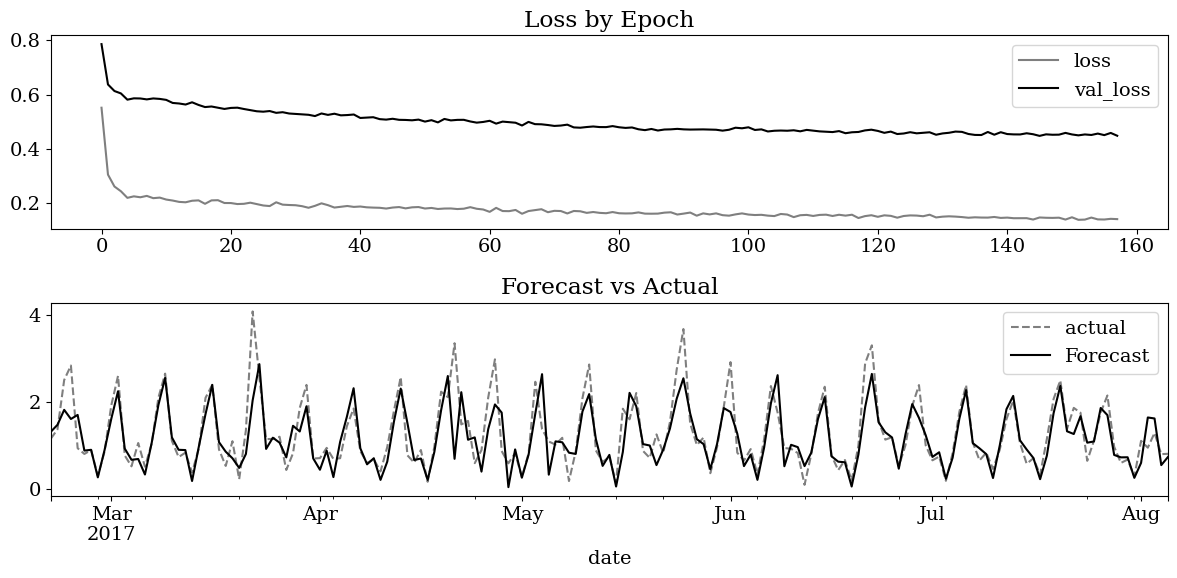

Mean Absolute Percentage Error: 30.12%


In [506]:
plot_forecast(model_a_simpleRNN, X_test, y_test, test_data.index, history_a_simpleRNN)

## LSTM

In [507]:
tf.keras.backend.clear_session()

In [508]:
from tensorflow.keras.layers import LSTM

In [509]:
model_a_lstm = create_model(LSTM,train=X_train, units=32)
model_a_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [510]:
history_a_lstm = train_model_ts(model_a_lstm, X_train, y_train, X_val, y_val)

Epoch 1/500
43/43 [==============================] - 3s 18ms/step - loss: 0.8858 - root_mean_squared_error: 0.9411 - mean_absolute_error: 0.7418 - val_loss: 1.2672 - val_root_mean_squared_error: 1.1257 - val_mean_absolute_error: 0.8235
Epoch 2/500
43/43 [==============================] - 0s 7ms/step - loss: 0.4750 - root_mean_squared_error: 0.6892 - mean_absolute_error: 0.5404 - val_loss: 0.8941 - val_root_mean_squared_error: 0.9456 - val_mean_absolute_error: 0.7255
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 0.4701 - root_mean_squared_error: 0.6857 - mean_absolute_error: 0.5401 - val_loss: 0.8784 - val_root_mean_squared_error: 0.9373 - val_mean_absolute_error: 0.7230
Epoch 4/500
43/43 [==============================] - 0s 8ms/step - loss: 0.4622 - root_mean_squared_error: 0.6799 - mean_absolute_error: 0.5380 - val_loss: 0.8842 - val_root_mean_squared_error: 0.9403 - val_mean_absolute_error: 0.7176
Epoch 5/500
43/43 [==============================] - 0s 7ms

Epoch 36/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1970 - root_mean_squared_error: 0.4438 - mean_absolute_error: 0.2999 - val_loss: 0.4987 - val_root_mean_squared_error: 0.7062 - val_mean_absolute_error: 0.4494
Epoch 37/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461 - mean_absolute_error: 0.3036 - val_loss: 0.4883 - val_root_mean_squared_error: 0.6988 - val_mean_absolute_error: 0.4434
Epoch 38/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463 - mean_absolute_error: 0.2997 - val_loss: 0.4841 - val_root_mean_squared_error: 0.6958 - val_mean_absolute_error: 0.4422
Epoch 39/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415 - mean_absolute_error: 0.2981 - val_loss: 0.4706 - val_root_mean_squared_error: 0.6860 - val_mean_absolute_error: 0.4385
Epoch 40/500
43/43 [==============================] - 0s

Epoch 71/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1602 - root_mean_squared_error: 0.4003 - mean_absolute_error: 0.2651 - val_loss: 0.4238 - val_root_mean_squared_error: 0.6510 - val_mean_absolute_error: 0.4351
Epoch 72/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1573 - root_mean_squared_error: 0.3966 - mean_absolute_error: 0.2612 - val_loss: 0.4182 - val_root_mean_squared_error: 0.6467 - val_mean_absolute_error: 0.4341
Epoch 73/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1518 - root_mean_squared_error: 0.3896 - mean_absolute_error: 0.2573 - val_loss: 0.4151 - val_root_mean_squared_error: 0.6443 - val_mean_absolute_error: 0.4351
Epoch 74/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1527 - root_mean_squared_error: 0.3908 - mean_absolute_error: 0.2550 - val_loss: 0.4167 - val_root_mean_squared_error: 0.6455 - val_mean_absolute_error: 0.4349
Epoch 75/500
43/43 [==============================] - 0s

Epoch 106/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1318 - root_mean_squared_error: 0.3630 - mean_absolute_error: 0.2385 - val_loss: 0.3855 - val_root_mean_squared_error: 0.6209 - val_mean_absolute_error: 0.4249
Epoch 107/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1365 - root_mean_squared_error: 0.3695 - mean_absolute_error: 0.2408 - val_loss: 0.3871 - val_root_mean_squared_error: 0.6222 - val_mean_absolute_error: 0.4263
Epoch 108/500
43/43 [==============================] - 0s 8ms/step - loss: 0.1346 - root_mean_squared_error: 0.3669 - mean_absolute_error: 0.2378 - val_loss: 0.3965 - val_root_mean_squared_error: 0.6297 - val_mean_absolute_error: 0.4287
Epoch 109/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1330 - root_mean_squared_error: 0.3647 - mean_absolute_error: 0.2347 - val_loss: 0.3900 - val_root_mean_squared_error: 0.6245 - val_mean_absolute_error: 0.4266
Epoch 110/500
43/43 [==============================]

In [511]:
model_a_lstm.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.2965 - root_mean_squared_error: 0.5446 - mean_absolute_error: 0.3600


[0.2965405285358429, 0.5445553660392761, 0.3600442707538605]

6/6 [==============================] - 0s 4ms/step


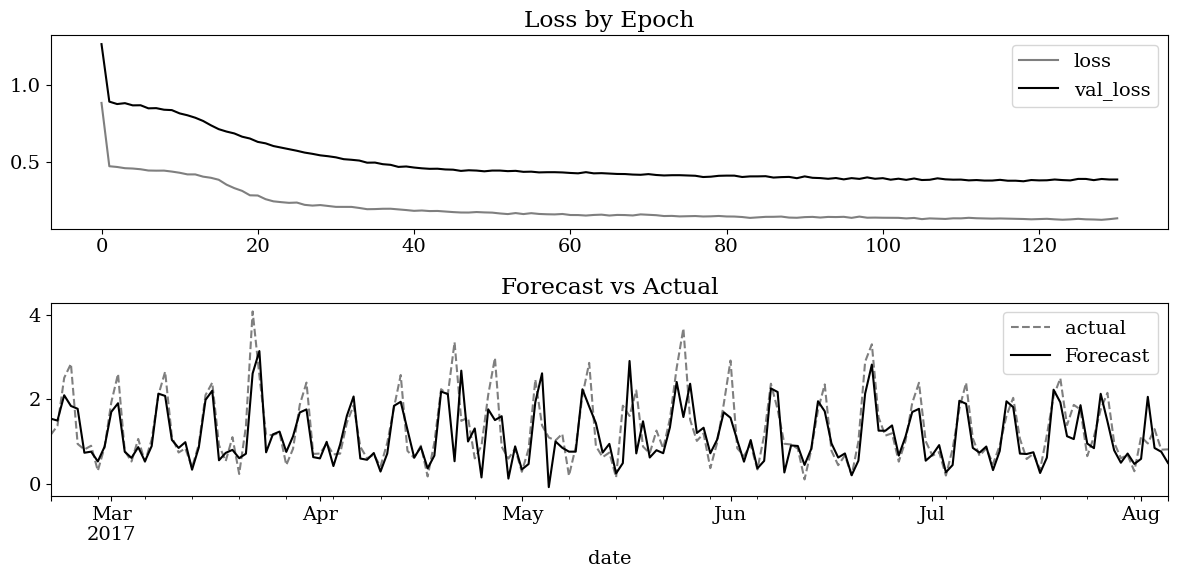

Mean Absolute Percentage Error: 33.32%


In [512]:
plot_forecast(model_a_lstm, X_test, y_test, test_data.index, history_a_lstm)

## GRU

In [513]:
tf.keras.backend.clear_session()

In [514]:
from tensorflow.keras.layers import GRU

In [515]:
model_a_gru = create_model(GRU,train=X_train, units=32)
history_a_gru = train_model_ts(model_a_gru, X_train, y_train, X_val, y_val)

Epoch 1/500
43/43 [==============================] - 3s 18ms/step - loss: 0.5296 - root_mean_squared_error: 0.7277 - mean_absolute_error: 0.5669 - val_loss: 0.9062 - val_root_mean_squared_error: 0.9519 - val_mean_absolute_error: 0.7250
Epoch 2/500
43/43 [==============================] - 0s 8ms/step - loss: 0.4446 - root_mean_squared_error: 0.6668 - mean_absolute_error: 0.5308 - val_loss: 0.8696 - val_root_mean_squared_error: 0.9325 - val_mean_absolute_error: 0.7092
Epoch 3/500
43/43 [==============================] - 0s 8ms/step - loss: 0.4250 - root_mean_squared_error: 0.6519 - mean_absolute_error: 0.5233 - val_loss: 0.8329 - val_root_mean_squared_error: 0.9126 - val_mean_absolute_error: 0.6930
Epoch 4/500
43/43 [==============================] - 0s 8ms/step - loss: 0.4025 - root_mean_squared_error: 0.6344 - mean_absolute_error: 0.5052 - val_loss: 0.7859 - val_root_mean_squared_error: 0.8865 - val_mean_absolute_error: 0.6718
Epoch 5/500
43/43 [==============================] - 0s 8ms

Epoch 36/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1731 - root_mean_squared_error: 0.4160 - mean_absolute_error: 0.2726 - val_loss: 0.4151 - val_root_mean_squared_error: 0.6443 - val_mean_absolute_error: 0.4196
Epoch 37/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1674 - root_mean_squared_error: 0.4092 - mean_absolute_error: 0.2711 - val_loss: 0.4183 - val_root_mean_squared_error: 0.6467 - val_mean_absolute_error: 0.4189
Epoch 38/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1664 - root_mean_squared_error: 0.4079 - mean_absolute_error: 0.2685 - val_loss: 0.4131 - val_root_mean_squared_error: 0.6427 - val_mean_absolute_error: 0.4180
Epoch 39/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1602 - root_mean_squared_error: 0.4002 - mean_absolute_error: 0.2650 - val_loss: 0.4112 - val_root_mean_squared_error: 0.6412 - val_mean_absolute_error: 0.4160
Epoch 40/500
43/43 [==============================] - 0s

6/6 [==============================] - 0s 4ms/step


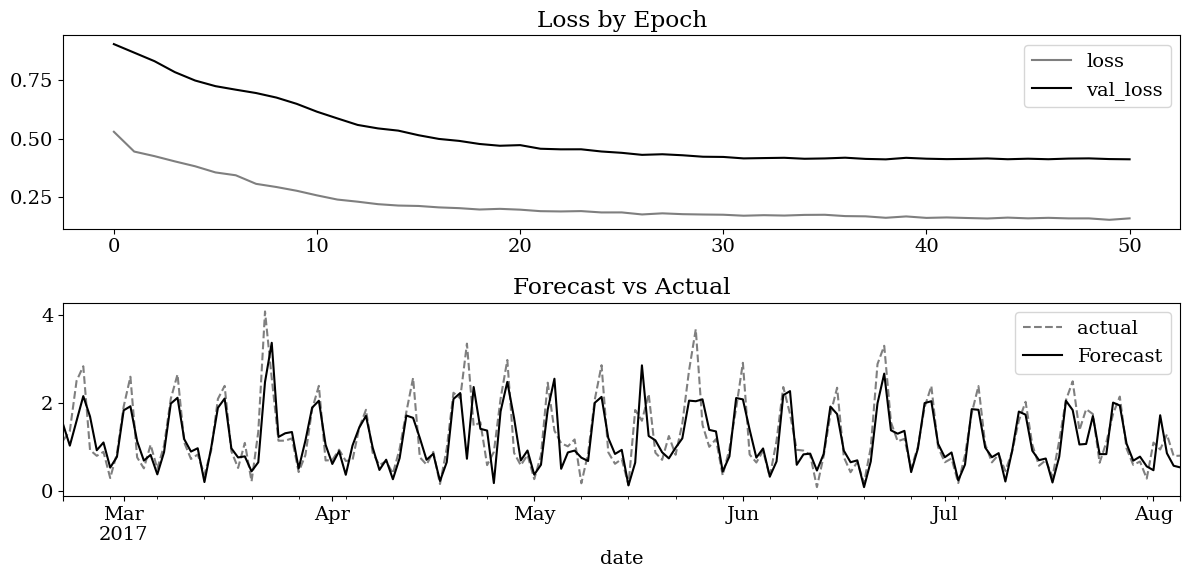

Mean Absolute Percentage Error: 30.71%


In [516]:
plot_forecast(model_a_gru, X_test, y_test, test_data.index, history_a_gru)

## Deep RNN + LSTM

In [517]:
tf.keras.backend.clear_session()

In [518]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [519]:
model_a_deep = create_model(train=X_train, units=32)
history_a_deep = train_model_ts(model_a_deep, X_train, y_train, X_val, y_val)

Epoch 1/500
43/43 [==============================] - 5s 29ms/step - loss: 0.6351 - root_mean_squared_error: 0.7970 - mean_absolute_error: 0.6176 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9180 - val_mean_absolute_error: 0.7411
Epoch 2/500
43/43 [==============================] - 0s 11ms/step - loss: 0.4737 - root_mean_squared_error: 0.6883 - mean_absolute_error: 0.5403 - val_loss: 0.8487 - val_root_mean_squared_error: 0.9213 - val_mean_absolute_error: 0.7243
Epoch 3/500
43/43 [==============================] - 0s 11ms/step - loss: 0.4791 - root_mean_squared_error: 0.6922 - mean_absolute_error: 0.5478 - val_loss: 0.8456 - val_root_mean_squared_error: 0.9196 - val_mean_absolute_error: 0.7222
Epoch 4/500
43/43 [==============================] - 0s 11ms/step - loss: 0.4724 - root_mean_squared_error: 0.6873 - mean_absolute_error: 0.5384 - val_loss: 0.8386 - val_root_mean_squared_error: 0.9157 - val_mean_absolute_error: 0.7227
Epoch 5/500
43/43 [==============================] - 0s 

Epoch 36/500
43/43 [==============================] - 0s 11ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845 - mean_absolute_error: 0.3365 - val_loss: 0.4763 - val_root_mean_squared_error: 0.6901 - val_mean_absolute_error: 0.4644
Epoch 37/500
43/43 [==============================] - 0s 10ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846 - mean_absolute_error: 0.3367 - val_loss: 0.4891 - val_root_mean_squared_error: 0.6994 - val_mean_absolute_error: 0.4703
Epoch 38/500
43/43 [==============================] - 0s 10ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742 - mean_absolute_error: 0.3271 - val_loss: 0.4753 - val_root_mean_squared_error: 0.6894 - val_mean_absolute_error: 0.4566
Epoch 39/500
43/43 [==============================] - 0s 10ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738 - mean_absolute_error: 0.3275 - val_loss: 0.4740 - val_root_mean_squared_error: 0.6885 - val_mean_absolute_error: 0.4593
Epoch 40/500
43/43 [==============================] 

In [520]:
model_a_deep.evaluate(X_test, y_test)

6/6 [==============================] - 0s 5ms/step - loss: 0.3226 - root_mean_squared_error: 0.5679 - mean_absolute_error: 0.3900


[0.32255879044532776, 0.5679426193237305, 0.3899681866168976]

6/6 [==============================] - 1s 4ms/step


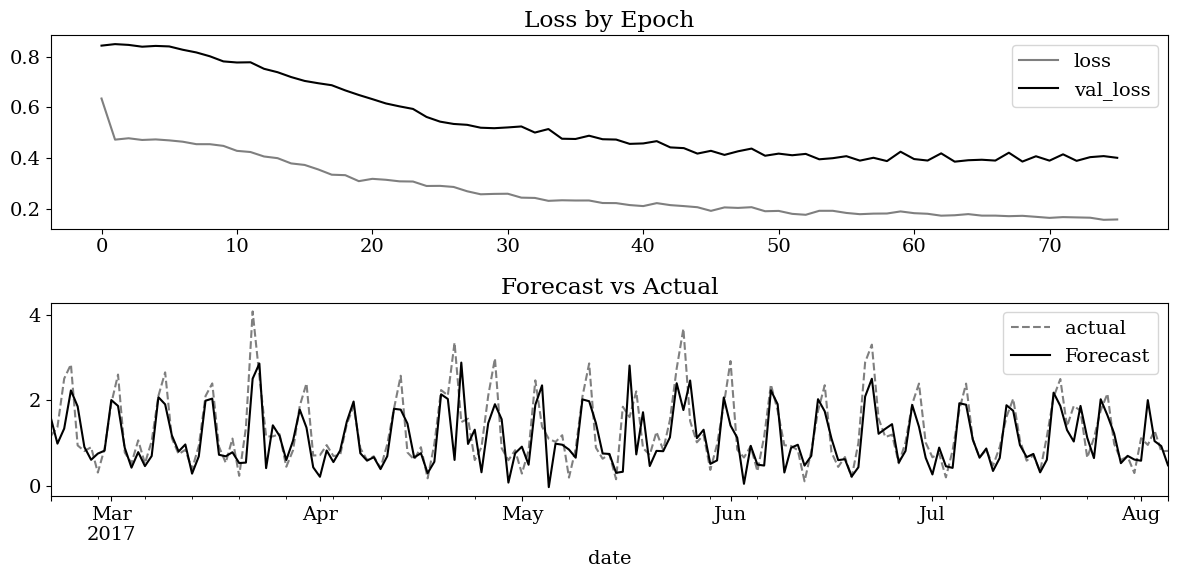

Mean Absolute Percentage Error: 38.12%


In [521]:
plot_forecast(model_a_deep, X_test, y_test, test_data.index, history_a_deep)

## Timedistributed

In [522]:
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()

In [523]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

In [524]:
model_a_td = create_model(train=X_train, units=32)
history_a_td = train_model_ts(model_a_td, X_train, y_train, X_val, y_val)

Epoch 1/500
43/43 [==============================] - 5s 30ms/step - loss: 0.8124 - root_mean_squared_error: 0.9013 - mean_absolute_error: 0.7084 - val_loss: 1.3095 - val_root_mean_squared_error: 1.1443 - val_mean_absolute_error: 0.8689
Epoch 2/500
43/43 [==============================] - 0s 10ms/step - loss: 0.6139 - root_mean_squared_error: 0.7835 - mean_absolute_error: 0.6070 - val_loss: 1.2021 - val_root_mean_squared_error: 1.0964 - val_mean_absolute_error: 0.8288
Epoch 3/500
43/43 [==============================] - 0s 11ms/step - loss: 0.6080 - root_mean_squared_error: 0.7798 - mean_absolute_error: 0.6096 - val_loss: 1.1507 - val_root_mean_squared_error: 1.0727 - val_mean_absolute_error: 0.8080
Epoch 4/500
43/43 [==============================] - 0s 10ms/step - loss: 0.5764 - root_mean_squared_error: 0.7592 - mean_absolute_error: 0.5889 - val_loss: 1.0998 - val_root_mean_squared_error: 1.0487 - val_mean_absolute_error: 0.7953
Epoch 5/500
43/43 [==============================] - 0s 

Epoch 36/500
43/43 [==============================] - 0s 10ms/step - loss: 0.4492 - root_mean_squared_error: 0.6703 - mean_absolute_error: 0.5014 - val_loss: 0.9212 - val_root_mean_squared_error: 0.9598 - val_mean_absolute_error: 0.7030
Epoch 37/500
43/43 [==============================] - 0s 10ms/step - loss: 0.4460 - root_mean_squared_error: 0.6678 - mean_absolute_error: 0.4983 - val_loss: 0.9184 - val_root_mean_squared_error: 0.9583 - val_mean_absolute_error: 0.6999
Epoch 38/500
43/43 [==============================] - 0s 10ms/step - loss: 0.4428 - root_mean_squared_error: 0.6655 - mean_absolute_error: 0.4954 - val_loss: 0.9159 - val_root_mean_squared_error: 0.9570 - val_mean_absolute_error: 0.6971
Epoch 39/500
43/43 [==============================] - 0s 10ms/step - loss: 0.4401 - root_mean_squared_error: 0.6634 - mean_absolute_error: 0.4928 - val_loss: 0.9097 - val_root_mean_squared_error: 0.9538 - val_mean_absolute_error: 0.6933
Epoch 40/500
43/43 [==============================] 

Epoch 105/500
43/43 [==============================] - 0s 11ms/step - loss: 0.3639 - root_mean_squared_error: 0.6033 - mean_absolute_error: 0.4200 - val_loss: 0.8135 - val_root_mean_squared_error: 0.9019 - val_mean_absolute_error: 0.6434
Epoch 106/500
43/43 [==============================] - 0s 10ms/step - loss: 0.3633 - root_mean_squared_error: 0.6027 - mean_absolute_error: 0.4192 - val_loss: 0.8228 - val_root_mean_squared_error: 0.9071 - val_mean_absolute_error: 0.6497
Epoch 107/500
43/43 [==============================] - 0s 11ms/step - loss: 0.3630 - root_mean_squared_error: 0.6025 - mean_absolute_error: 0.4193 - val_loss: 0.8123 - val_root_mean_squared_error: 0.9013 - val_mean_absolute_error: 0.6431
Epoch 108/500
43/43 [==============================] - 0s 10ms/step - loss: 0.3624 - root_mean_squared_error: 0.6020 - mean_absolute_error: 0.4185 - val_loss: 0.8225 - val_root_mean_squared_error: 0.9069 - val_mean_absolute_error: 0.6501
Epoch 109/500
43/43 [===========================

In [525]:
model_a_td.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 0s 6ms/step - loss: 0.5777 - root_mean_squared_error: 0.7600 - mean_absolute_error: 0.5279


[0.5776662230491638, 0.7600435614585876, 0.5279203653335571]

6/6 [==============================] - 1s 4ms/step


ValueError: Length of values (1670) does not match length of index (167)

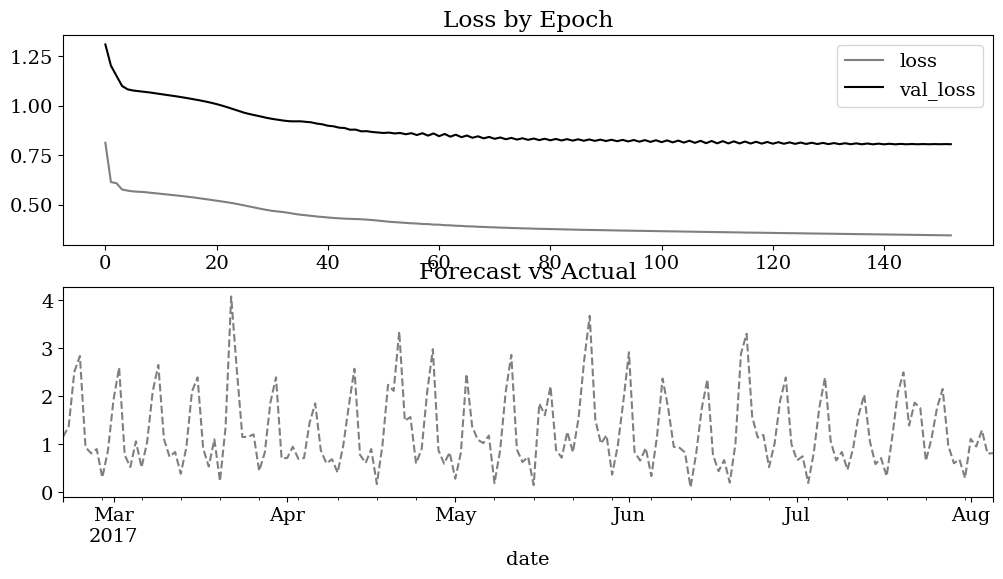

In [526]:
plot_forecast(model_a_td, X_test, y_test, test_data.index, history_a_td)